# **Desafio 02 - Predição com Dados de Iot**

## **1. Objetivo**

Para esse desafio, a IBM disponibilizou um broker MQTT disponível online. Esse broker está capturando dados de sensores IoT em loop, e publicando-os no tópico ```quanam``` e devemos capturá-los. No total, são 3200 amostras de dados diferentes, cada uma tende os valores de co2, temperatura, humidade, som, iluminação e ritmo cardíaco, juntamente com um número identificador (id) da amostra, variando de 1 até 3200. O primeiro passo é a captura dos dados do broker.

Credenciais :
```
HOST : iot.maratona.dev
PORT : 31666
USERNAME : maratoners
PASSWORD : btc-2021
```

Para a captura dos danos podemos utilizar o cliente Python paho-mqtt.

A partir dos dados obtidos via IoT, iremos realizar uma predição de qual será o ritmo cardíaco de uma pessoa para saber se está em risco ou não. Portanto, após agrupar esses dados, a nossa tarefa é criar um modelo de **regressão**, capaz de predizer qual será o ritmo cardíaco de um paciente baseando-se nas medidas.

## **2. Resgatando os dados com paho-mqtt**

Abaixo, iremos utilizar o pacote ```paho-mqtt``` para lermos os dados que estão sendo disponibilizados através do endereço ```iot.maratona.dev``` na porta ```31666``` e realizar o armazenamento no arquivo ```data_mqtt.csv```.

**OBS : Como já temos o arquivo ```data_mqtt.csv``` não é necessário realizar novamente esse etapa.**

In [1]:
import paho.mqtt.client as mqtt
import json

In [2]:
address = "iot.maratona.dev"
port = 31666
username = "maratoners"
password = "btc-2021"

In [7]:
def on_connect(client, userdata, flags, rc): #Chamado após utilizarmos client.connect
    print(f"Conectado com o código : {rc}") #Verificar se a conexão funcionou --> 0 = Funcionou
    print("Resgatando os dados do tópico quanam...\n")
    client.subscribe("quanam") #Subscrever no tópico quanam para pegar os dados
    
def on_message(client, userdata, msg):
    message = json.loads(msg.payload.decode()) #Resgatando os dados e passando para o formato json
    data_list.append(message) #Realizando o append para a lista
    
    if len(data_list) == 3200 : #Criando um if para desconectar do client e parar de resgatar os dados
        print("Dados resgatados!")
        client.disconnect() #Desconectar
        print("Realizando a criação do arquivo CSV...")
        pd.DataFrame(data_list).to_csv("data_mqtt.csv", index=False) #Criação de um .csv com os dados capturados
        print("Finalizada a criação do arquivo CSV!")

data_list = [] #Criação de uma lista para armazenar os dados

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message
client.username_pw_set(username=username, password=password) #Setar o usuário e a senha para se conectar e pegar os dados
client.connect(host = address, port = 31666) #Conexão passando o endereço e a porta
client.loop_forever() #Loop para pegar as mensagens, será parado quando entrar no "if" dentro de "on_message"

Conectado com o código : 0
Resgatando os dados do tópico quanam...

Dados resgatados!
Realizando a criação do arquivo CSV...
Finalizada a criação do arquivo CSV!


7

## **3. Importação dos Pacotes**

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## **4. Importação dos dados**

Visto que já realizamos o armazenamento em ```data_mqtt.csv```, podemos realizar apenas o import através do pacote Pandas utilizando o ```pd.read_csv()```.

Abaixo também podemos perceber que nosso arquivo possui 3200 linhas, que vão do ```ID``` 1 até 3200, conforme informado no objetivo do projeto.

As variáveis independentes / preditoras da nossa tabela de dados são :

```ILLUM``` : Iluminação do ambiente medida em **Lux** <br/>
```HUMID``` : Umidade do ambiente medida em **%** <br/>
```CO2``` : CO2 do ambiente medido em **PPM (partes por milhão)** <br/>
```SOUND``` : Som do ambiente medido em **dB** <br/>
```TEMP``` : Temperatura do ambiente medida em **Celsius(°C)**

In [31]:
df_original = pd.read_csv("assets/data_mqtt.csv")
answers = pd.read_csv("assets/answers.csv")

In [32]:
print(f"O identificador (ID) vai de {df_original['ID'].min()} à {df_original['ID'].max()}.")

O identificador (ID) vai de 1 à 3200.


Também irei realizar a ordenação por ```ID``` e setaremos o mesmo como index do nosso DataFrame, visto que não é necessário utilizar o mesmo para as futuras operações.

In [33]:
df_original = df_original.sort_values('ID').set_index("ID")
df_mqtt = df_original.copy()
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
ID,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39
2,387.14,70.23,501.81,25.93,18.77,85.17
3,339.75,74.72,535.88,30.50,19.41,80.76
4,390.19,63.83,422.76,24.18,17.41,63.55
5,454.11,70.64,619.85,16.50,20.31,83.19


Abaixo, temos o nosso DataFrame ```answers```, que será necessário alterar os valores da coluna ```RYTHM``` (variável que será prevista) para submetermos posteriormente para a página do desafio.

In [34]:
answers.head()

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
0,0,337.90,63.29,518.13,22.38,18.59,0.0
1,1,342.96,63.19,488.85,37.36,20.41,0.0
2,2,369.86,57.39,516.86,26.45,20.89,0.0
3,3,304.65,67.80,517.50,32.98,22.52,0.0
4,4,442.25,68.21,500.91,37.28,21.88,0.0


## **5. Análise Exploratória dos Dados**

Podemos verificar que nossas variáveis não possuem valores nulos e já estão com o tipo de dado ```float64``` para a representação de valores decimais.

In [35]:
df_mqtt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 1 to 3200
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ILLUM   3200 non-null   float64
 1   HUMID   3200 non-null   float64
 2   CO2     3200 non-null   float64
 3   SOUND   3200 non-null   float64
 4   TEMP    3200 non-null   float64
 5   RYTHM   3200 non-null   float64
dtypes: float64(6)
memory usage: 175.0 KB


Realizando uma verificação com o ```.describe()``` podemos notar uma diiferença na escala dos dados e um alto valor de desvio padrão para as variáveis ```ILLUM``` e ```CO2```, o que significa uma alta dispersão dos dados.

In [36]:
df_mqtt.describe()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,439.163412,67.086106,501.620666,29.840194,20.042578,80.156616
std,89.915142,4.776214,42.951183,6.158710,1.648479,6.755854
min,145.480000,51.860000,352.820000,8.060000,14.760000,55.370000
25%,377.060000,63.770000,471.427500,25.550000,18.920000,75.657500
50%,437.375000,66.935000,502.350000,29.885000,20.050000,80.220000
75%,500.792500,70.330000,530.142500,33.932500,21.180000,84.660000
max,775.140000,83.900000,672.380000,53.780000,26.290000,108.900000


Também podemos verificar a assimetria (grau de desvio ou afastamento da simetriia de uma distribuição) e a curtose (grau de achatamento de uma distribuição) dos dados.

Para a interpretação dos resultados :

**Assimetria / Skewness**
- Menor que 0 : Moda > Mediana > Média, possui uma "cauda" alongada para a esquerda e os valores se concentram na extremidade superior da escala. 
- Maior que 0 : Média > Mediana > Moda, possui uma "cauda" alongada para a direita e os valores se concentram na extremidade inferior da escala.
- Igual à 0 : Média = Mediana = Moda, é considerado uma distribuição aproximadamente simétrica.

**Curtose / Kurtosis**
- Menor que 0,263 : Curva Leptocúrtica, significa que é mais pontiaguda que a normal.
- Maior que 0,263 : Curva Platicúrtica, significa que a distribuição é mais achatada que a normal
- Igual à 0,263 : Curva Mesocúrtica, significa uma distribuição normal.

In [37]:
for column in df_mqtt.columns :
    print(f"{column} :\nAssimetria {df_mqtt[column].skew()}\nCurtose {df_mqtt[column].kurt()}\n")

ILLUM :
Assimetria 0.004455861478176452
Curtose -0.05016242661992587

HUMID :
Assimetria 0.10130227087549776
Curtose -0.11257905244816513

CO2 :
Assimetria 0.03778716254155882
Curtose 0.02697360910560853

SOUND :
Assimetria -0.038358324402207725
Curtose 0.012987556810277301

TEMP :
Assimetria 0.01446209465404037
Curtose -0.13376251061464517

RYTHM :
Assimetria 0.004693343407667097
Curtose 0.076786699449372



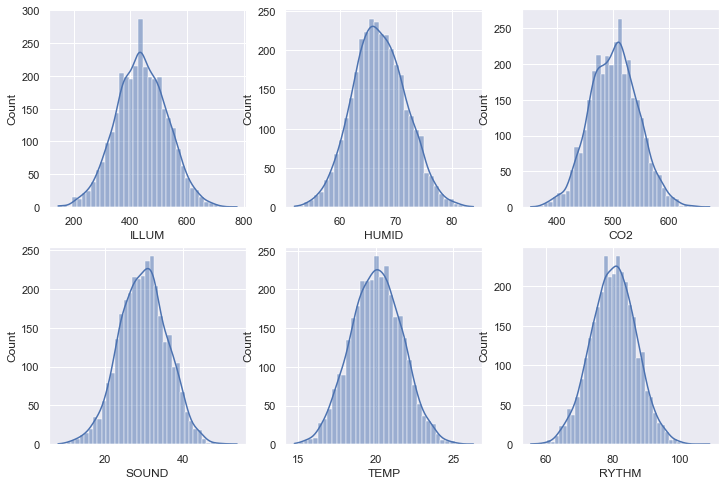

In [38]:
fig, axes = plt.subplots(2,3,figsize=(12,8))
ax_row, ax_col = 0, 0

for column in df_mqtt.columns :
    sns.histplot(data=df_mqtt, x=column, kde=True, ax=axes[ax_row][ax_col])
    ax_col += 1
    if ax_col == 3 :
        ax_col = 0
        ax_row += 1

ILLUM:
6 outliers abaixo
9 outliers acima

HUMID:
3 outliers abaixo
13 outliers acima

CO2:
9 outliers abaixo
10 outliers acima

SOUND:
15 outliers abaixo
7 outliers acima

TEMP:
8 outliers abaixo
10 outliers acima

RYTHM:
10 outliers abaixo
13 outliers acima



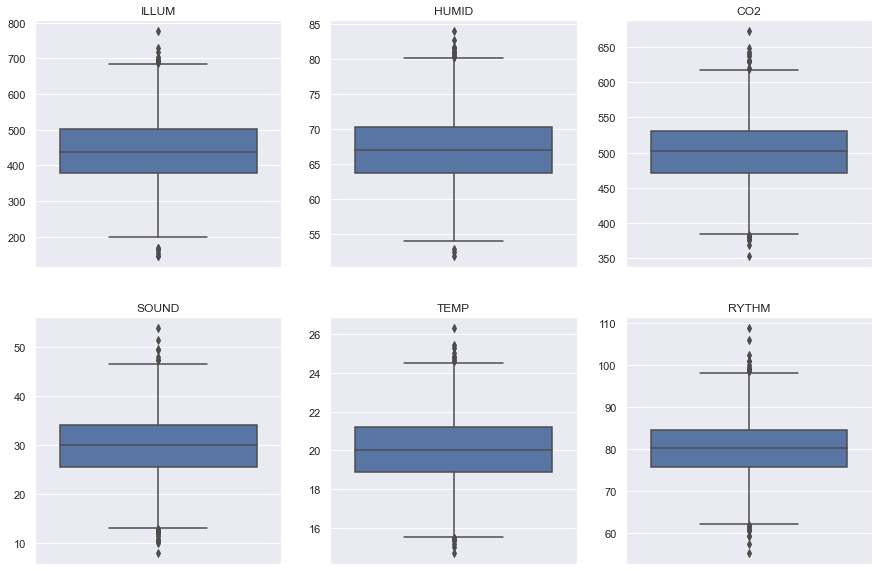

In [39]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
ax_row, ax_col = 0, 0

for column in df_mqtt.columns :
    
    q1 = np.percentile(df_mqtt[column], 25) 
    q3 = np.percentile(df_mqtt[column], 75)
    iqr = q3 - q1
    lower_outlier = q1 - (1.5 * iqr)
    upper_outlier = q3 + (1.5 * iqr)

    
    print(f"{column}:\n{len(df_mqtt[df_mqtt[column] < lower_outlier])} outliers abaixo\n{len(df_mqtt[df_mqtt[column] > upper_outlier])} outliers acima\n")
    
    sns.boxplot(data = df_mqtt, y = column, ax = axes[ax_row][ax_col])
    sns.lineplot()
    axes[ax_row][ax_col].set_title(column)
    axes[ax_row][ax_col].set_ylabel("")
    
    ax_col += 1
    if ax_col == 3 :
        ax_col = 0
        ax_row += 1
    

Verificando a correlação entre as variáveis, não conseguimos encontrar uma forte ou moderada correlação positiva / negativa entre as nossas variáveis.

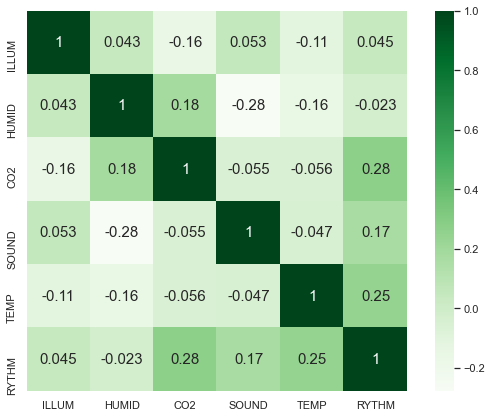

In [40]:
plt.figure(figsize=(10,7))
sns.heatmap(df_mqtt.corr(),square=True, annot = True, annot_kws={'size':15}, cmap="Greens")
plt.show()

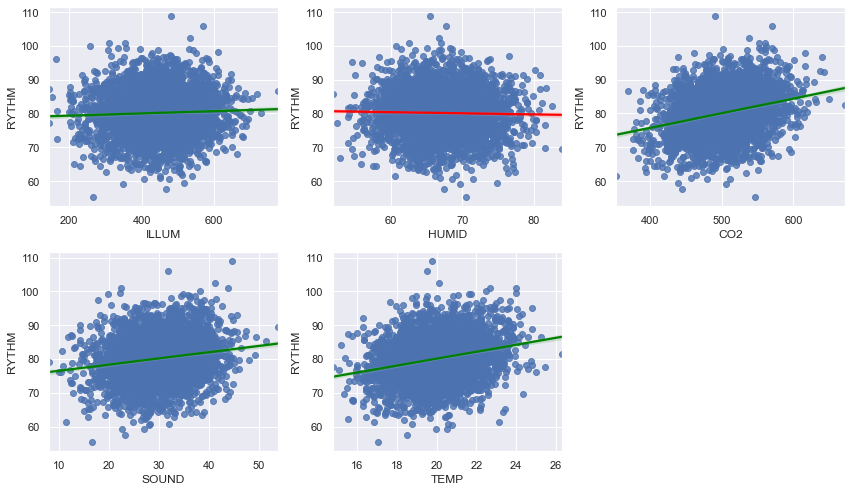

In [41]:
fig, axes = plt.subplots(2, 3, figsize = (12,7))
ax_row, ax_col = 0, 0
colors = ['green' if df_mqtt[column].corr(df_mqtt['RYTHM']) > 0 else 'red' for column in df_mqtt.drop('RYTHM', axis = 1).columns]

for index, column in enumerate(df_mqtt.drop('RYTHM', axis = 1).columns) :
    sns.regplot(data = df_mqtt, x = column, y = 'RYTHM', ax = axes[ax_row][ax_col], line_kws={'color' : f'{colors[index]}'})
    axes[ax_row][ax_col].set_xlim(df_mqtt[column].min())
    ax_col += 1
    if ax_col == 3 :
        ax_col = 0
        ax_row += 1

axes[1][2].set_visible(False)      
plt.tight_layout()

## **6. Criação de Novas Variáveis**

In [42]:
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
ID,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39
2,387.14,70.23,501.81,25.93,18.77,85.17
3,339.75,74.72,535.88,30.50,19.41,80.76
4,390.19,63.83,422.76,24.18,17.41,63.55
5,454.11,70.64,619.85,16.50,20.31,83.19


In [43]:
df_mqtt['ILLUM'].describe()

count    3200.000000
mean      439.163412
std        89.915142
min       145.480000
25%       377.060000
50%       437.375000
75%       500.792500
max       775.140000
Name: ILLUM, dtype: float64

In [44]:
df_mqtt['ILLUM'].describe()

count    3200.000000
mean      439.163412
std        89.915142
min       145.480000
25%       377.060000
50%       437.375000
75%       500.792500
max       775.140000
Name: ILLUM, dtype: float64

In [45]:
# Baseado em https://www.thegreenage.co.uk/lux-much-light-need/
def illum_levels(lux) :
    if (lux >= 145) & (lux < 300):
        return 1
    elif (lux >= 300) & (lux < 500) :
        return 2
    elif lux >= 500 :
        return 3

df_mqtt['ILLUM_LEVELS'] = df_mqtt['ILLUM'].map(illum_levels).astype('int64')
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ILLUM_LEVELS
ID,,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39,2
2,387.14,70.23,501.81,25.93,18.77,85.17,2
3,339.75,74.72,535.88,30.50,19.41,80.76,2
4,390.19,63.83,422.76,24.18,17.41,63.55,2
5,454.11,70.64,619.85,16.50,20.31,83.19,2


In [46]:
df_mqtt['CO2_LEVELS'] = df_mqtt['CO2'].map(lambda co2 : 1 if co2 < 500 else 2)
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ILLUM_LEVELS,CO2_LEVELS
ID,,,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39,2,1
2,387.14,70.23,501.81,25.93,18.77,85.17,2,2
3,339.75,74.72,535.88,30.50,19.41,80.76,2,2
4,390.19,63.83,422.76,24.18,17.41,63.55,2,1
5,454.11,70.64,619.85,16.50,20.31,83.19,2,2


In [47]:
# Criação de Coluna para Índice de Calor (determina o efeito da umidade relativa sobre a temperatura aparente do ar, sendo utilizado para medir qual a intensidade do calor que uma pessoa sente)
# https://pt.wikipedia.org/wiki/%C3%8Dndice_de_calor
def heat_index(df) :
    
    humid = df['HUMID']
    temp_celsius = df['TEMP']
    temp_fahrenheit = 1.8 * temp_celsius + 32
    
    constant = -42.379 + (2.04901523 * temp_fahrenheit) + (10.14333127 * humid) + (-0.22475541 * temp_fahrenheit * humid) + (-6.83783e-3 * (temp_fahrenheit ** 2)) + (-5.481717e-2 * (humid ** 2)) + (1.2222874e-3 * (temp_fahrenheit ** 2) * humid) \
    + (8.5282e-4 * temp_fahrenheit * (humid ** 2)) + (-1.99e-6 * (temp_fahrenheit ** 2) * (humid ** 2))
    
    heat = 5/9 * (constant - 32)
    
    return heat
    
df_mqtt['HEAT_INDEX'] = df_mqtt.apply(heat_index, axis = 1)
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ILLUM_LEVELS,CO2_LEVELS,HEAT_INDEX
ID,,,,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39,2,1,23.308713
2,387.14,70.23,501.81,25.93,18.77,85.17,2,2,22.309745
3,339.75,74.72,535.88,30.50,19.41,80.76,2,2,21.119696
4,390.19,63.83,422.76,24.18,17.41,63.55,2,1,24.422312
5,454.11,70.64,619.85,16.50,20.31,83.19,2,2,21.875301


In [48]:
df_mqtt['ILLUM_LEVELS'].value_counts()

2    2193
3     815
1     192
Name: ILLUM_LEVELS, dtype: int64

In [49]:
df_mqtt['CO2_LEVELS'].value_counts()

2    1665
1    1535
Name: CO2_LEVELS, dtype: int64

Podemos notar uma grande correlação negativa entre ```HUMID``` e ```HEAT_INDEX``` de -0.81287

In [50]:
print('CORRELAÇÃO HEAT_INDEX COM OUTRAS COLUNAS')
for column in df_mqtt.drop(['RYTHM', 'HEAT_INDEX'], axis = 1).columns :
    print(f"HEAT_INDEX com {column} : {df_mqtt['HEAT_INDEX'].corr(df_mqtt[column])}")

print(f"\nHEAT_INDEX com variável target (RYTHM) : {df_mqtt['HEAT_INDEX'].corr(df_mqtt['RYTHM'])}")

CORRELAÇÃO HEAT_INDEX COM OUTRAS COLUNAS
HEAT_INDEX com ILLUM : -0.008993764580458688
HEAT_INDEX com HUMID : -0.8128777488742444
HEAT_INDEX com CO2 : -0.13291345986394246
HEAT_INDEX com SOUND : 0.23809574923201585
HEAT_INDEX com TEMP : -0.16459338223746386
HEAT_INDEX com ILLUM_LEVELS : -0.02045927959704413
HEAT_INDEX com CO2_LEVELS : -0.11883910120799634

HEAT_INDEX com variável target (RYTHM) : -0.04857070466151136


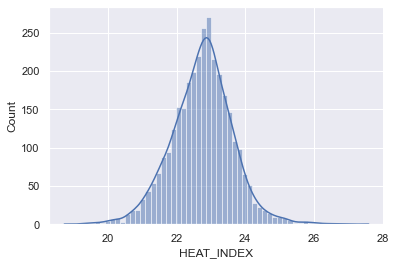

In [51]:
sns.histplot(data=df_mqtt, x='HEAT_INDEX', kde=True)
plt.show()

In [52]:
# https://thinkmetric.uk/basics/temperature/
def temp_map(temp) :
    if temp <= 15 :
        return 1
    elif (temp > 15) & (temp <= 20) :
        return 2
    elif (temp > 20) & (temp <= 25) :
        return 3
    else :
        return 4

df_mqtt['TEMP_LEVELS'] = df_mqtt['TEMP'].map(temp_map)
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ILLUM_LEVELS,CO2_LEVELS,HEAT_INDEX,TEMP_LEVELS
ID,,,,,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39,2,1,23.308713,3
2,387.14,70.23,501.81,25.93,18.77,85.17,2,2,22.309745,2
3,339.75,74.72,535.88,30.50,19.41,80.76,2,2,21.119696,2
4,390.19,63.83,422.76,24.18,17.41,63.55,2,1,24.422312,2
5,454.11,70.64,619.85,16.50,20.31,83.19,2,2,21.875301,3


<AxesSubplot:>

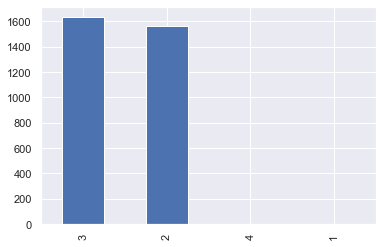

In [53]:
df_mqtt['TEMP_LEVELS'].value_counts().plot(kind = 'bar')

In [54]:
def sound_map(sound) :
    if sound <= 26 :
        return 1
    elif (sound > 26) & (sound <= 32) :
        return 2
    else :
        return 3
    
df_mqtt['SOUND_LEVELS'] = df_mqtt['SOUND'].map(sound_map)
df_mqtt.head()

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM,ILLUM_LEVELS,CO2_LEVELS,HEAT_INDEX,TEMP_LEVELS,SOUND_LEVELS
ID,,,,,,,,,,,
1,467.90,65.59,486.10,41.06,23.27,92.39,2,1,23.308713,3,3
2,387.14,70.23,501.81,25.93,18.77,85.17,2,2,22.309745,2,1
3,339.75,74.72,535.88,30.50,19.41,80.76,2,2,21.119696,2,2
4,390.19,63.83,422.76,24.18,17.41,63.55,2,1,24.422312,2,1
5,454.11,70.64,619.85,16.50,20.31,83.19,2,2,21.875301,3,1


<AxesSubplot:>

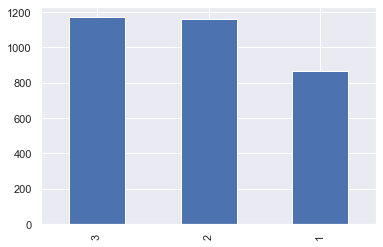

In [55]:
df_mqtt['SOUND_LEVELS'].value_counts().plot(kind='bar')

In [56]:
y = df_mqtt['RYTHM']
df_mqtt = df_mqtt.drop('RYTHM', axis = 1)
df_mqtt['RYTHM'] = y
df_mqtt

,ILLUM,HUMID,CO2,SOUND,TEMP,ILLUM_LEVELS,CO2_LEVELS,HEAT_INDEX,TEMP_LEVELS,SOUND_LEVELS,RYTHM
ID,,,,,,,,,,,
1,467.90,65.59,486.10,41.06,23.27,2,1,23.308713,3,3,92.39
2,387.14,70.23,501.81,25.93,18.77,2,2,22.309745,2,1,85.17
3,339.75,74.72,535.88,30.50,19.41,2,2,21.119696,2,2,80.76
4,390.19,63.83,422.76,24.18,17.41,2,1,24.422312,2,1,63.55
5,454.11,70.64,619.85,16.50,20.31,2,2,21.875301,3,1,83.19
...,...,...,...,...,...,...,...,...,...,...,...
3196,549.06,67.97,553.70,27.40,16.49,3,2,24.458138,2,2,76.93
3197,408.51,63.25,516.07,28.51,20.22,2,2,23.058819,3,2,84.96
3198,459.01,56.65,453.37,25.81,19.04,2,1,24.290019,2,1,83.65


## **7. Pré-Processamento dos Dados**

In [57]:
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

In [58]:
df_mqtt_alt = df_mqtt.copy()

In [59]:
num_features = df_mqtt_alt.select_dtypes('float64').iloc[:,:-1].columns
cat_features = df_mqtt_alt.select_dtypes(exclude='float64').columns

In [60]:
one_hot = OneHotEncoder(cols=cat_features)
std_scaler = StandardScaler()

df_mqtt_alt[num_features] = std_scaler.fit_transform(df_mqtt_alt[num_features])
df_mqtt_alt = one_hot.fit_transform(df_mqtt_alt)
df_mqtt_alt

,ILLUM,HUMID,CO2,SOUND,TEMP,ILLUM_LEVELS_1,ILLUM_LEVELS_2,ILLUM_LEVELS_3,CO2_LEVELS_1,CO2_LEVELS_2,HEAT_INDEX,TEMP_LEVELS_1,TEMP_LEVELS_2,TEMP_LEVELS_3,TEMP_LEVELS_4,SOUND_LEVELS_1,SOUND_LEVELS_2,SOUND_LEVELS_3,RYTHM
ID,,,,,,,,,,,,,,,,,,,
1,0.319647,-0.313290,-0.361412,1.822063,1.958124,1,0,0,1,0,0.630188,1,0,0,0,1,0,0,92.39
2,-0.578674,0.658343,0.004409,-0.635004,-0.772092,1,0,0,0,1,-0.478795,0,1,0,0,0,1,0,85.17
3,-1.105809,1.598565,0.797759,0.107151,-0.383794,1,0,0,0,1,-1.799901,0,1,0,0,0,0,1,80.76
4,-0.544748,-0.681840,-1.836340,-0.919199,-1.597223,1,0,0,1,0,1.866426,0,1,0,0,0,1,0,63.55
5,0.166256,0.744198,2.753075,-2.166408,0.162249,1,0,0,0,1,-0.961083,1,0,0,0,0,1,0,83.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1.222417,0.185091,1.212713,-0.396280,-2.155401,0,1,0,0,1,1.906197,0,1,0,0,0,0,1,76.93
3197,-0.340968,-0.803294,0.336466,-0.216020,0.107644,1,0,0,0,1,0.352773,1,0,0,0,0,0,1,84.96
3198,0.220760,-2.185358,-1.123559,-0.654492,-0.608279,1,0,0,1,0,1.719563,0,1,0,0,0,1,0,83.65


In [99]:
def agrupa_rythm(df) :
    lista = list(df['RYTHM'].value_counts()[df['RYTHM'].value_counts() > 1].index)
    df_group = df.query('RYTHM not in @lista').append(df.query('RYTHM in @lista').sort_values('RYTHM').groupby('RYTHM').mean().reset_index(), ignore_index = True)
    return df_group

In [100]:
df_groupby = agrupa_rythm(df_mqtt)
df_groupby

,ILLUM,HUMID,CO2,SOUND,TEMP,ILLUM_LEVELS,CO2_LEVELS,HEAT_INDEX,TEMP_LEVELS,SOUND_LEVELS,RYTHM
0,467.900,65.590,486.100,41.06,23.270,2.0,1.0,23.308713,3.0,3.0,92.39
1,390.190,63.830,422.760,24.18,17.410,2.0,1.0,24.422312,2.0,1.0,63.55
2,479.500,66.940,498.020,17.82,22.350,2.0,1.0,22.760437,3.0,1.0,97.33
3,516.290,52.920,468.850,29.80,19.590,3.0,1.0,24.348451,2.0,2.0,66.72
4,470.310,59.730,421.780,33.12,20.820,2.0,1.0,23.383614,3.0,3.0,74.52
...,...,...,...,...,...,...,...,...,...,...,...
1823,400.315,65.380,495.520,36.11,21.845,2.0,1.5,22.794224,3.0,3.0,94.70
1824,481.360,68.430,522.615,30.03,21.060,2.5,2.0,22.282984,3.0,2.5,95.05
1825,499.935,62.255,548.225,31.06,21.845,2.5,2.0,23.169682,3.0,2.0,95.14
1826,382.475,65.675,520.250,39.16,21.645,2.0,2.0,22.803035,3.0,3.0,95.23


## **8. Criação dos Modelos**

In [493]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [617]:
def roda_modelo(model, X, y, name_df, name_model, resultados):
    r2_scores = []
    r2_adj_scores = []
    rmse_scores = []
    
    rfk = RepeatedKFold(n_splits=3, n_repeats=20, random_state=42)
    
    for linhas_treino, linhas_valid in rfk.split(X) :

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
       
        modelo = model
        modelo.fit(X_treino, y_treino)
    
        p = modelo.predict(X_valid)
    
        r2 = r2_score(y_valid, p)
        
        n = len(X_valid)
        k = len(X_valid.columns)
        r2_adj = 1 - ((1-r2)* (n-1) / (n-k-1))
        
        rmse = mean_squared_error(y_valid, p, squared = False)
    
        r2_scores.append(r2)
        r2_adj_scores.append(r2_adj)
        rmse_scores.append(rmse)
        

    resultados = resultados.append({'DataFrame' : name_df, 'Modelo' : name_model, 'R2' : np.mean(r2_scores), 'R2_adj' : np.mean(r2_adj_scores), 'RMSE' : np.mean(rmse_scores)}, ignore_index=True)
    return resultados

In [495]:
resultados = pd.DataFrame(columns=['DataFrame', 'Modelo', 'R2', 'R2_adj', 'RMSE'])

In [496]:
X = df_original.iloc[:,:-1]
y = df_original.iloc[:,-1]

models = [('Ridge', Ridge()),
          ('Linear', LinearRegression())]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'Original', name, resultados)

In [497]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412


In [498]:
df_groupby_original = agrupa_rythm(df_original)

X = df_groupby_original.iloc[:,:-1]
y = df_groupby_original.iloc[:,-1]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'Group_Original', name, resultados)

In [499]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412
2,Group_Original,Ridge,0.305099,0.301272,6.501090
3,Group_Original,Linear,0.305098,0.301272,6.501091


In [500]:
X = df_mqtt.iloc[:,:-1]
y = df_mqtt.iloc[:,-1]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'Mqtt', name, resultados)

In [501]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412
2,Group_Original,Ridge,0.305099,0.301272,6.501090
3,Group_Original,Linear,0.305098,0.301272,6.501091
4,Mqtt,Ridge,0.192787,0.187707,6.067144
5,Mqtt,Linear,0.192759,0.187679,6.067248


In [502]:
df_groupby_mqtt = agrupa_rythm(df_mqtt)

X = df_groupby_mqtt.iloc[:,:-1]
y = df_groupby_mqtt.iloc[:,-1]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'Group_Mqtt', name, resultados)

In [503]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412
2,Group_Original,Ridge,0.305099,0.301272,6.501090
3,Group_Original,Linear,0.305098,0.301272,6.501091
4,Mqtt,Ridge,0.192787,0.187707,6.067144
5,Mqtt,Linear,0.192759,0.187679,6.067248
6,Group_Mqtt,Ridge,0.300545,0.292799,6.522309
7,Group_Mqtt,Linear,0.300431,0.292683,6.522841


In [504]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_original.iloc[:,:-1]), columns = df_original.columns[:-1])
y = df_original.iloc[:,-1]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'StdScaler_Original', name, resultados)

In [505]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412
2,Group_Original,Ridge,0.305099,0.301272,6.501090
3,Group_Original,Linear,0.305098,0.301272,6.501091
4,Mqtt,Ridge,0.192787,0.187707,6.067144
5,Mqtt,Linear,0.192759,0.187679,6.067248
6,Group_Mqtt,Ridge,0.300545,0.292799,6.522309
7,Group_Mqtt,Linear,0.300431,0.292683,6.522841
8,StdScaler_Original,Ridge,0.194056,0.191528,6.062402
9,StdScaler_Original,Linear,0.194054,0.191525,6.062412


In [506]:
df_groupby_original = agrupa_rythm(df_original)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_groupby_original.iloc[:,:-1]), columns = df_groupby_original.columns[:-1])
y = df_groupby_original.iloc[:,-1]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'StdScaler_Group_Original', name, resultados)

In [507]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412
2,Group_Original,Ridge,0.305099,0.301272,6.501090
3,Group_Original,Linear,0.305098,0.301272,6.501091
4,Mqtt,Ridge,0.192787,0.187707,6.067144
5,Mqtt,Linear,0.192759,0.187679,6.067248
6,Group_Mqtt,Ridge,0.300545,0.292799,6.522309
7,Group_Mqtt,Linear,0.300431,0.292683,6.522841
8,StdScaler_Original,Ridge,0.194056,0.191528,6.062402
9,StdScaler_Original,Linear,0.194054,0.191525,6.062412


In [508]:
df_groupby_original = agrupa_rythm(df_original)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(df_groupby_original.iloc[:,:-1]), columns = df_groupby_original.columns[:-1])
y = df_groupby_original.iloc[:,-1]

for name, model in models :
    resultados = roda_modelo(model, X, y, 'MinMaxScaler_Group_Original', name, resultados)

In [509]:
resultados

,DataFrame,Modelo,R2,R2_adj,RMSE
0,Original,Ridge,0.194054,0.191526,6.062411
1,Original,Linear,0.194054,0.191525,6.062412
2,Group_Original,Ridge,0.305099,0.301272,6.501090
3,Group_Original,Linear,0.305098,0.301272,6.501091
4,Mqtt,Ridge,0.192787,0.187707,6.067144
5,Mqtt,Linear,0.192759,0.187679,6.067248
6,Group_Mqtt,Ridge,0.300545,0.292799,6.522309
7,Group_Mqtt,Linear,0.300431,0.292683,6.522841
8,StdScaler_Original,Ridge,0.194056,0.191528,6.062402
9,StdScaler_Original,Linear,0.194054,0.191525,6.062412


## **-------------- MODELO FINAL --------------**

In [530]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [540]:
df_original = pd.read_csv("assets/data_mqtt.csv")
answers = pd.read_csv("assets/answers.csv")
answers_modify = answers.copy()

In [541]:
df_original = df_original.sort_values("ID").set_index("ID")
answers_modify = answers_modify.drop('ID', axis=1)

In [544]:
def agrupa_rythm(df) :
    lista = list(df['RYTHM'].value_counts()[df['RYTHM'].value_counts() > 1].index)
    df_group = df.query('RYTHM not in @lista').append(df.query('RYTHM in @lista').sort_values('RYTHM').groupby('RYTHM').mean().reset_index(), ignore_index = True)
    return df_group

df_group = agrupa_rythm(df_original)
df_group

,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
0,467.900,65.590,486.100,41.06,23.270,92.39
1,390.190,63.830,422.760,24.18,17.410,63.55
2,479.500,66.940,498.020,17.82,22.350,97.33
3,516.290,52.920,468.850,29.80,19.590,66.72
4,470.310,59.730,421.780,33.12,20.820,74.52
...,...,...,...,...,...,...
1823,400.315,65.380,495.520,36.11,21.845,94.70
1824,481.360,68.430,522.615,30.03,21.060,95.05
1825,499.935,62.255,548.225,31.06,21.845,95.14
1826,382.475,65.675,520.250,39.16,21.645,95.23


In [656]:
X = df_groupby_original.iloc[:,:-1]
y = df_groupby_original.iloc[:,-1]
X_answers = answers_modify.iloc[:,:-1]

model = Ridge()
model.fit(X, y)
p = model.predict(X_answers)

In [662]:
answers['RYTHM'] = p
answers.to_csv('answers.csv', index=False)